# imports

In [2]:
from binance.client import Client
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pandas as pd
from itertools import product
from tqdm import tqdm
import plotly.graph_objects as go
import yaml

pd.set_option('display.max_columns', None)

from utils.indicators import calculate_ema, calculate_bollinger_bands, get_data_for_emas_strategy_backtesting, \
                             get_emas_strategy_trades_not_vectorized, get_emas_strategy_trades_vectorized, get_data_for_bollinger_bands_backtesting, \
                             get_kpis   

# Conf: skip to 'Read BTCUSDT data' if only reading data

get you API keys: https://cryptopro.app/help/automatic-import/binance-api-key/

In [11]:
with open('conf.yaml', 'r') as file:
    data = yaml.safe_load(file)

API_KEY = data['API_KEY']
API_SECRET = data['API_SECRET']

# Get BTCUSDT data: skip to 'Read BTCUSDT data' if only reading data

In [ ]:
client = Client(API_KEY, API_SECRET)

# Define the parameters
symbol = 'BTCUSDT'
interval = Client.KLINE_INTERVAL_1HOUR
start_date = '2022-01-01'
end_date = '2025-01-01'

# Fetch historical klines
klines = client.get_historical_klines(
    symbol=symbol,
    interval=interval,
    start_str=start_date,
    end_str=end_date
)

In [ ]:
# Convert to a DataFrame for better readability and analysis
columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 
           'close_time', 'quote_asset_volume', 'number_of_trades', 
           'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore']

df = pd.DataFrame(klines, columns=columns)

# Convert timestamp to a readable datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
df['close_time'] = pd.to_datetime(df['close_time'], unit='ms')

# Drop unnecessary columns (optional)
df = df[['timestamp', 'open', 'high', 'low', 'close', 'volume']]
df[['open', 'high', 'low', 'close', 'volume']] = df[['open', 'high', 'low', 'close', 'volume']].astype(float)

# Save to a CSV file (optional)
#df.to_csv(r'data\btcusdt_1h_ohlcv.csv', index=False)

# Read BTCUSDT data

In [6]:
df = pd.read_csv(r'data\btcusdt_1h_ohlcv.csv')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26304 entries, 0 to 26303
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  26304 non-null  object 
 1   open       26304 non-null  float64
 2   high       26304 non-null  float64
 3   low        26304 non-null  float64
 4   close      26304 non-null  float64
 5   volume     26304 non-null  float64
dtypes: float64(5), object(1)
memory usage: 1.2+ MB


In [10]:
df.tail()

timestamp      open      high       low     close     volume
26299  2024-12-31 20:00:00  94166.88  94222.50  93450.17  93564.04  733.04147
26300  2024-12-31 21:00:00  93564.01  93964.15  93504.67  93899.68  337.52715
26301  2024-12-31 22:00:00  93899.67  93899.67  93375.58  93488.84  315.53272
26302  2024-12-31 23:00:00  93488.83  93756.00  93375.38  93576.00  336.57995
26303  2025-01-01 00:00:00  93576.00  94509.42  93489.03  94401.14  755.99010

# Plotting the data

### Matplotlib

In [56]:
n = 1000
df_head_n = df.head(n)

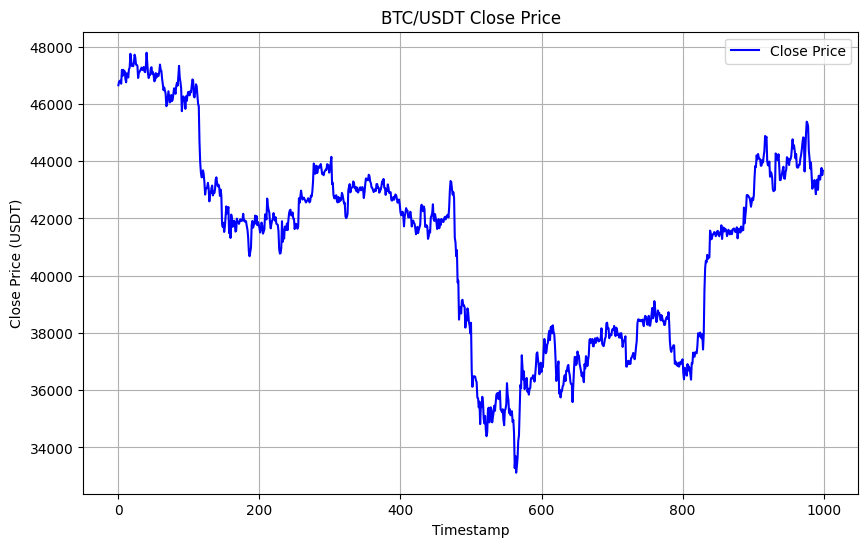

In [60]:
plt.figure(figsize=(10, 6))
plt.plot(df_head_n['close'], label='Close Price', color='blue')
plt.title('BTC/USDT Close Price')
plt.xlabel('Timestamp')
plt.ylabel('Close Price (USDT)')
plt.legend()
plt.grid()
plt.show()

# Plotly

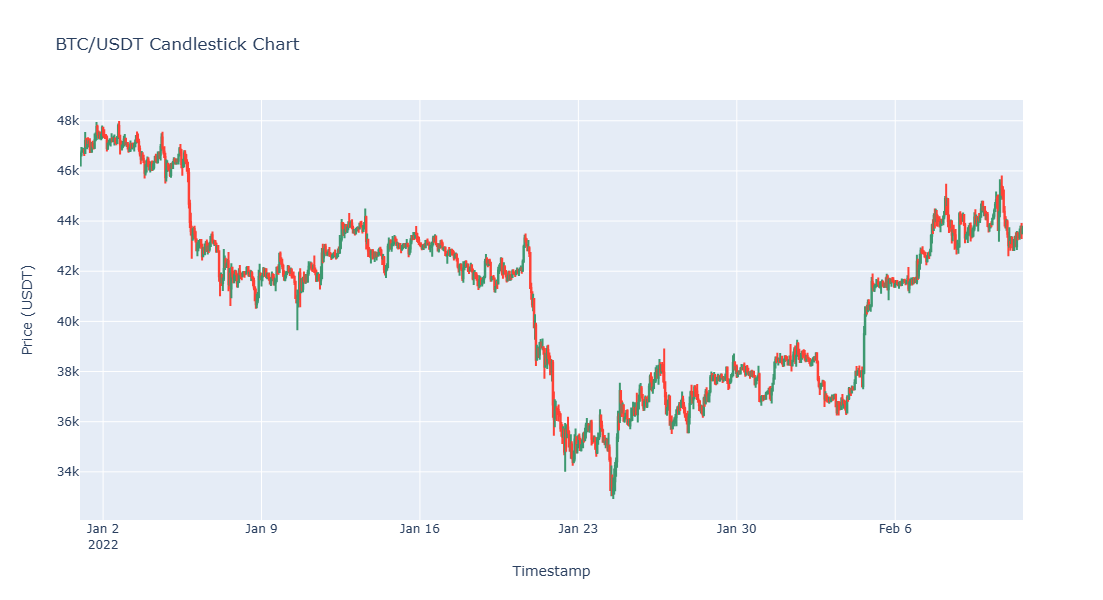

In [80]:
fig = go.Figure(data=[go.Candlestick(
    x=df_head_n['timestamp'],
    open=df_head_n['open'],
    high=df_head_n['high'],
    low=df_head_n['low'],
    close=df_head_n['close']
)])

fig.update_layout(
    title='BTC/USDT Candlestick Chart',
    xaxis_title='Timestamp',
    yaxis_title='Price (USDT)',
    xaxis_rangeslider_visible=False,
    width = 1000,
    height = 600
)

fig.show()

# Calculating indicators

In [12]:
with open(r'conf\conf-indicators.yaml', 'r') as file:
    data = yaml.safe_load(file)

In [14]:
ema_periods = []

for ema_number in [1, 2, 3, 4]:
    for ema_period in data[f'ema{ema_number}']:
        ema_periods.append(ema_period)

ema_periods.sort()  
df_with_emas = calculate_ema(df,
                             periods = ema_periods, 
                             price_column = 'close')

# Backtesting EMA only strategy

In [10]:
all_kpis = []

for ema1, ema2, ema3, ema4 in tqdm(list(product(data['ema1'], data['ema2'], data['ema3'], data['ema4'])), desc='ema combinations'):
    data_for_trades = get_data_for_emas_strategy_backtesting(
        df_with_emas,
        ema1,
        ema2,
        ema3,
        ema4)

    df_trades = get_emas_strategy_trades_vectorized(data_for_trades)
    #df_trades = get_emas_strategy_trades_not_vectorized(data_for_trades)

    params = {'ema1': ema1, 
              'ema2': ema2, 
              'ema3': ema3, 
              'ema4': ema4,
              'init_capital': 10000}
    df_kpis = get_kpis(df_trades, params)
    
    all_kpis.append(df_kpis)
df_all_kpis_emas_strategy = pd.DataFrame(all_kpis)

ema combinations: 100%|████████████████████████████████████████████████████████████████| 81/81 [00:01<00:00, 47.05it/s]


In [12]:
df_emas_strategy_data_with_best_params = get_data_for_emas_strategy_backtesting(data_for_trades,
                                                              ema_period1 = 5,
                                                              ema_period2 = 40,
                                                              ema_period3 = 80,
                                                              ema_period4 = 250)

df_best_trades = get_emas_strategy_trades_vectorized(df_emas_strategy_data_with_best_params)

### Visualizing capital evolution, indicators and orders

In [14]:
data_for_trades = get_data_for_bollinger_bands_backtesting(df_with_emas,
                                         5,
                                         40,
                                         80,
                                         250,
                                         20,
                                         2,
                                         bollinger_bands_buy_column = 'bollinger_upper_period',
                                         bollinger_bands_sell_column = 'bollinger_mid_period',
                                         using_emas = True)

In [16]:
data_for_trades

timestamp      open      high       low     close  \
0      2022-01-01 00:00:00  46216.93  46731.39  46208.37  46656.13   
1      2022-01-01 01:00:00  46656.14  46949.99  46574.06  46778.14   
2      2022-01-01 02:00:00  46778.14  46928.94  46721.96  46811.77   
3      2022-01-01 03:00:00  46811.77  46916.63  46760.12  46813.20   
4      2022-01-01 04:00:00  46813.21  46887.33  46591.23  46711.05   
...                    ...       ...       ...       ...       ...   
26299  2024-12-31 20:00:00  94166.88  94222.50  93450.17  93564.04   
26300  2024-12-31 21:00:00  93564.01  93964.15  93504.67  93899.68   
26301  2024-12-31 22:00:00  93899.67  93899.67  93375.58  93488.84   
26302  2024-12-31 23:00:00  93488.83  93756.00  93375.38  93576.00   
26303  2025-01-01 00:00:00  93576.00  94509.42  93489.03  94401.14   

           volume         ema_5        ema_10        ema_15        ema_20  \
0      1503.33095  46656.130000  46656.130000  46656.130000  46656.130000   
1       943.81539  46696.800000  46678.313636  46671.381250  46667.750000   
2       485.16860  46735.123333  46702.578430  46688.929844  46681.466190   
3       562.88971  46761.148889  46722.691443  46704.463613  46694.012268   
4       861.88389  46744.449259  46720.574817  46705.286912  46695.634909   
...           ...           ...           ...           ...           ...   
26299   733.04147  94087.579951  94206.691142  94119.782481  94020.901882   
26300   337.52715  94024.946634  94150.870934  94092.269671  94009.356941   
26301   315.53272  93846.244423  94030.501673  94016.840962  93959.783899   
26302   336.57995  93756.162948  93947.865006  93961.735842  93923.233051   
26303   755.99010  93971.155299  94030.278641  94016.661362  93968.747999   

             ema_30        ema_40        ema_80       ema_100       ema_120  \
0      46656.130000  46656.130000  46656.130000  46656.130000  46656.130000   
1      46664.001613  46662.081707  46659.142593  46658.546040  46658.146694   
2      46673.535057  46669.383575  46662.911171  46661.580177  46660.685922   
3      46682.545699  46676.399011  46666.622006  46664.582550  46663.206816   
4      46684.384686  46678.089303  46667.718993  46665.502698  46663.997613   
...             ...           ...           ...           ...           ...   
26299  93903.771389  93878.410850  94132.917005  94321.077867  94517.239477   
26300  93903.507428  93879.448369  94127.158067  94312.733355  94507.031882   
26301  93876.754691  93860.394302  94111.397127  94296.418635  94490.202264   
26302  93857.351162  93846.521409  94098.177445  94282.152919  94475.091483   
26303  93892.434313  93873.575975  94105.658002  94284.509099  94473.869145   

            ema_200       ema_250       ema_300  bollinger_mid_period  \
0      46656.130000  46656.130000  46656.130000                   NaN   
1      46657.344030  46657.102191  46656.940698                   NaN   
2      46658.880607  46658.334604  46657.969464                   NaN   
3      46660.416123  46659.568591  46659.000896                   NaN   
4      46660.919943  46659.978802  46659.346737                   NaN   
...             ...           ...           ...                   ...   
26299  95297.816525  95727.511283  96083.308216            93813.0035   
26300  95283.904719  95712.946890  96068.799059            93886.2090   
26301  95266.043378  95695.224923  96051.656474            93936.8335   
26302  95249.227026  95678.338668  96035.206929            93990.1540   
26303  95240.788350  95668.161787  96024.349341            94087.8110   

       bollinger_upper_period  bollinger_lower_period  emas_optimal_position  \
0                         NaN                     NaN                      1   
1                         NaN                     NaN                      1   
2                         NaN                     NaN                      1   
3                         NaN                     NaN                      1   
4                        

# Backtesting Bollinger bands + EMA strategy

### Bollinger bands alone

In [14]:
all_kpis = []

for ema1, ema2, ema3, ema4, bollinger_period, bollinger_std_mult in tqdm(list(product(data['ema1'], 
                                                data['ema2'], 
                                                data['ema3'], 
                                                data['ema4'],
                                                data['bollinger_band_periods'],
                                                data['bollinger_band_std_multipliers'])), desc='bollinger combinations'):
    data_for_trades = get_data_for_bollinger_bands_backtesting(df_with_emas,
                                             ema1,
                                             ema2,
                                             ema3,
                                             ema4,
                                             bollinger_period,
                                             bollinger_std_mult,
                                             bollinger_bands_buy_column = 'bollinger_upper_period',
                                             bollinger_bands_sell_column = 'bollinger_mid_period',
                                             using_emas = True)

    df_trades = get_emas_strategy_trades_vectorized(data_for_trades)
    #df_trades = get_emas_strategy_trades_not_vectorized(data_for_trades)

    params = {'ema1': ema1, 
              'ema2': ema2, 
              'ema3': ema3, 
              'ema4': ema4,
              'init_capital': 10000}
    df_kpis = get_kpis(df_trades, params)
    
    all_kpis.append(df_kpis)
df_all_kpis_emas_strategy = pd.DataFrame(all_kpis)

bollinger combinations:   0%|                                                                 | 0/2916 [00:00<?, ?it/s]


KeyError: 'bollinger_mid_period'

### Visualizing indicators and orders

In [16]:
df_emas_bollinger_bands_with_orders = get_data_for_bollinger_bands_backtesting(df_with_emas,
                                                                               ema_period1 = 5,
                                                                               ema_period2 = 40,
                                                                               ema_period3 = 100,
                                                                               ema_period4 = 200,
                                                                               bollinger_bands_period = 20,
                                                                               bollinger_bands_std_multiplier = 3,
                                                                               bollinger_bands_buy_column = 'bollinger_upper_period',
                                                                               bollinger_bands_sell_column = 'bollinger_mid_period',
                                                                               using_emas=False)

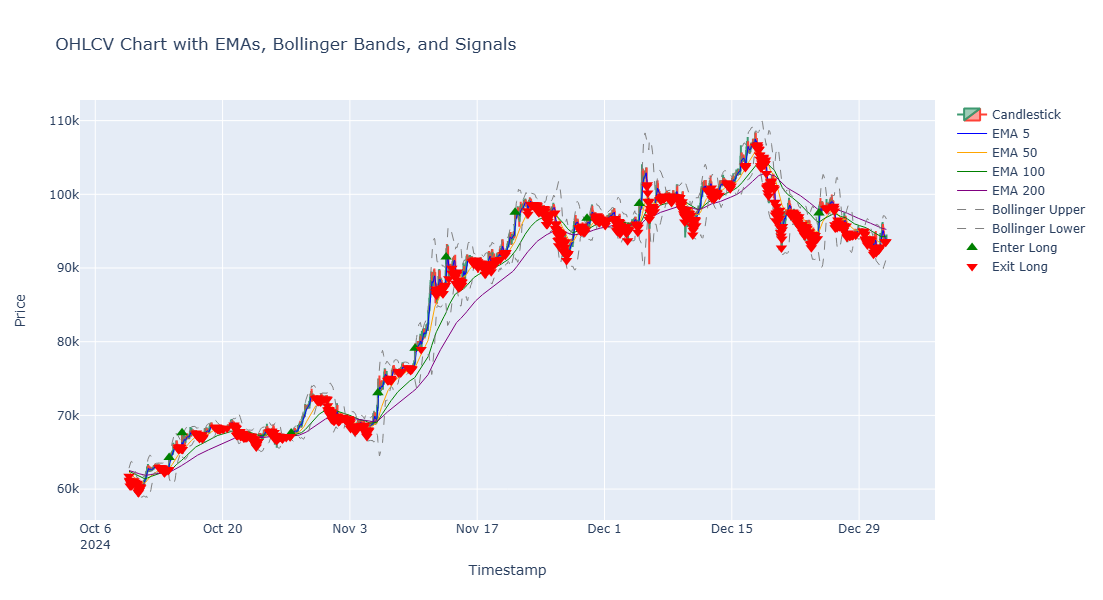

In [18]:
df_tail_n = df_emas_bollinger_bands_with_orders.tail(2000)
show_emas = True
show_bollinger = True

# Initialize the figure with the candlestick chart
fig = go.Figure(data=[go.Candlestick(
    x=df_tail_n['timestamp'],
    open=df_tail_n['open'],
    high=df_tail_n['high'],
    low=df_tail_n['low'],
    close=df_tail_n['close'],
    name='Candlestick'
)])
if show_emas:
    fig.add_trace(go.Scatter(
        x=df_tail_n['timestamp'],
        y=df_tail_n['ema_5'],
        mode='lines',
        line=dict(color='blue', width=1),
        name='EMA 5'
    ))
    fig.add_trace(go.Scatter(
        x=df_tail_n['timestamp'],
        y=df_tail_n['ema_40'],
        mode='lines',
        line=dict(color='orange', width=1),
        name='EMA 50'
    ))
    fig.add_trace(go.Scatter(
        x=df_tail_n['timestamp'],
        y=df_tail_n['ema_100'],
        mode='lines',
        line=dict(color='green', width=1),
        name='EMA 100'
    ))
    fig.add_trace(go.Scatter(
        x=df_tail_n['timestamp'],
        y=df_tail_n['ema_200'],
        mode='lines',
        line=dict(color='purple', width=1),
        name='EMA 200'
    ))

if show_bollinger:
    # Add Bollinger Bands
    fig.add_trace(go.Scatter(
        x=df_tail_n['timestamp'],
        y=df_tail_n['bollinger_upper_period'],
        mode='lines',
        line=dict(color='gray', width=1, dash='dash'),
        name='Bollinger Upper'
    ))
    fig.add_trace(go.Scatter(
        x=df_tail_n['timestamp'],
        y=df_tail_n['bollinger_lower_period'],
        mode='lines',
        line=dict(color='gray', width=1, dash='dash'),
        name='Bollinger Lower'
    ))
    
    # Add green triangles for `enterLong`
    fig.add_trace(go.Scatter(
        x=df_tail_n[df_tail_n['enterLong'] == 1]['timestamp'],
        y=df_tail_n[df_tail_n['enterLong'] == 1]['close'],
        mode='markers',
        marker=dict(symbol='triangle-up', color='green', size=10),
        name='Enter Long'
    ))

    # Add red triangles for `exitLong`
    fig.add_trace(go.Scatter(
        x=df_tail_n[df_tail_n['exitLong'] == 1]['timestamp'],
        y=df_tail_n[df_tail_n['exitLong'] == 1]['close'],
        mode='markers',
        marker=dict(symbol='triangle-down', color='red', size=10),
        name='Exit Long'
    ))

# Update layout
fig.update_layout(
    title='OHLCV Chart with EMAs, Bollinger Bands, and Signals',
    xaxis_title='Timestamp',
    yaxis_title='Price',
    xaxis_rangeslider_visible=False,
    width=1000,
    height=600
)

# Show the figure
fig.show()